In [14]:
import sys
import numpy as np
import tensorflow as tf
import PIL.Image

def gauss_kernel(size=5, sigma=1.0):
  grid = np.float32(np.mgrid[0:size,0:size].T)
  gaussian = lambda x: np.exp((x - size//2)**2/(-2*sigma**2))**2
  kernel = np.sum(gaussian(grid), axis=2)
  kernel /= np.sum(kernel)
  return kernel

def conv_gauss(t_input, stride=1, k_size=5, sigma=1.6, repeats=1):
  t_kernel = tf.reshape(tf.constant(gauss_kernel(size=k_size, sigma=sigma), tf.float32),
                        [k_size, k_size, 1, 1])
  t_kernel3 = tf.concat([t_kernel]*t_input.get_shape()[3], axis=2)
  t_result = t_input
  for r in range(repeats):
    t_result = tf.nn.depthwise_conv2d(t_result, t_kernel3,
        strides=[1, stride, stride, 1], padding='SAME')
  return t_result

def make_laplacian_pyramid(t_img, max_levels):
  t_pyr = []
  current = t_img
  for level in range(max_levels):
    t_gauss = conv_gauss(current, stride=1, k_size=5, sigma=2.0)
    t_diff = current - t_gauss
    t_pyr.append(t_diff)
    current = tf.nn.avg_pool(t_gauss, [1,2,2,1], [1,2,2,1], 'VALID')
  t_pyr.append(current)
  return t_pyr

def laploss(t_img1, t_img2, max_levels=3):
  t_pyr1 = make_laplacian_pyramid(t_img1, max_levels)
  t_pyr2 = make_laplacian_pyramid(t_img2, max_levels)
  return tf.size(t_pyr1[0], out_type=tf.float32)
  t_losses = [tf.norm(a-b,ord=1)/tf.size(a, out_type=tf.float32) for a,b in zip(t_pyr1, t_pyr2)]
  return (tf.reduce_sum(t_losses), tf.shape(t_img1, out_type=tf.float32))
  t_loss = tf.reduce_sum(t_losses)*tf.shape(t_img1, out_type=tf.float32)[0]
  return t_loss


In [15]:
assert len(sys.argv) == 3
## Test it:
BATCH_SIZE = 2
img1 = np.float32(PIL.Image.open("/Users/jedi/Projects/deep/DCGAN-tensorflow/data/img_align_celeba/000002.jpg"))/128.0 - 1.0
img2 = np.float32(PIL.Image.open("/Users/jedi/Projects/deep/DCGAN-tensorflow/data/img_align_celeba/000001.jpg"))/128.0 - 1.0
#import matplotlib.image as mpimg
#img1 = mpimg.imread("/Users/jedi/Projects/deep/DCGAN-tensorflow/data/img_align_celeba/000002.jpg")#)/128.0 - 1.0
#print(type(img1))
img1 = np.stack([img1]*BATCH_SIZE)
img2 = np.stack([img2]*BATCH_SIZE)


# Pretend it's two batches of 1 as [B,Y,X,C]
t_img1 = tf.constant(img1)
t_img2 = tf.constant(img2)
t_loss = laploss(t_img1, t_img2)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    t_loss = laploss(t_img1, t_img2)
    loss = sess.run(t_loss)
    loss_l1 = np.sum(np.abs(img1-img2))/np.prod(list(img1.shape)[1:])
    print "LapLoss, L1: ", loss, loss_l1



LapLoss, L1:  232824.0 1.3492414066


In [9]:
loss[0]*loss[1][0]

1.6824453

In [38]:
loss[1][:,:,1,:].reshape(5,5)

array([[ 0.02234067,  0.03481794,  0.04153446,  0.03481794,  0.02234067],
       [ 0.03481794,  0.04729521,  0.05401172,  0.04729521,  0.03481794],
       [ 0.04153446,  0.05401172,  0.06072824,  0.05401172,  0.04153446],
       [ 0.03481794,  0.04729521,  0.05401172,  0.04729521,  0.03481794],
       [ 0.02234067,  0.03481794,  0.04153446,  0.03481794,  0.02234067]], dtype=float32)

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

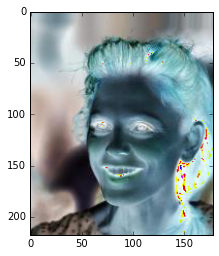

In [26]:
plt.imshow(np.float64(img1[0]))

In [13]:
img1.shape

(2, 218, 178, 3)